#  Trabalho 2 IA - Gabriel Benfatti de Campos

Classificação de espécies de pinguins

# 1. Setup

In [249]:
# modules and mount drive
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
# import from drive
import sys
sys.path.insert(0,'/content/drive/MyDrive/')
# module imported from drive
import quality as q # module i made to check dirty in file

# read data
df = pd.read_csv('/content/drive/MyDrive/csv/penguins_size.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Podemos reparar que ha dados faltando na base, portanto usaremos algumas tecnicas de analise visual para nos auxiliar na descoberta de inconsistencias na base.

# 2. 1. Pré-Processamento (Limpeza)

species               object
island                object
culmen_length_mm     float64
culmen_depth_mm      float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object


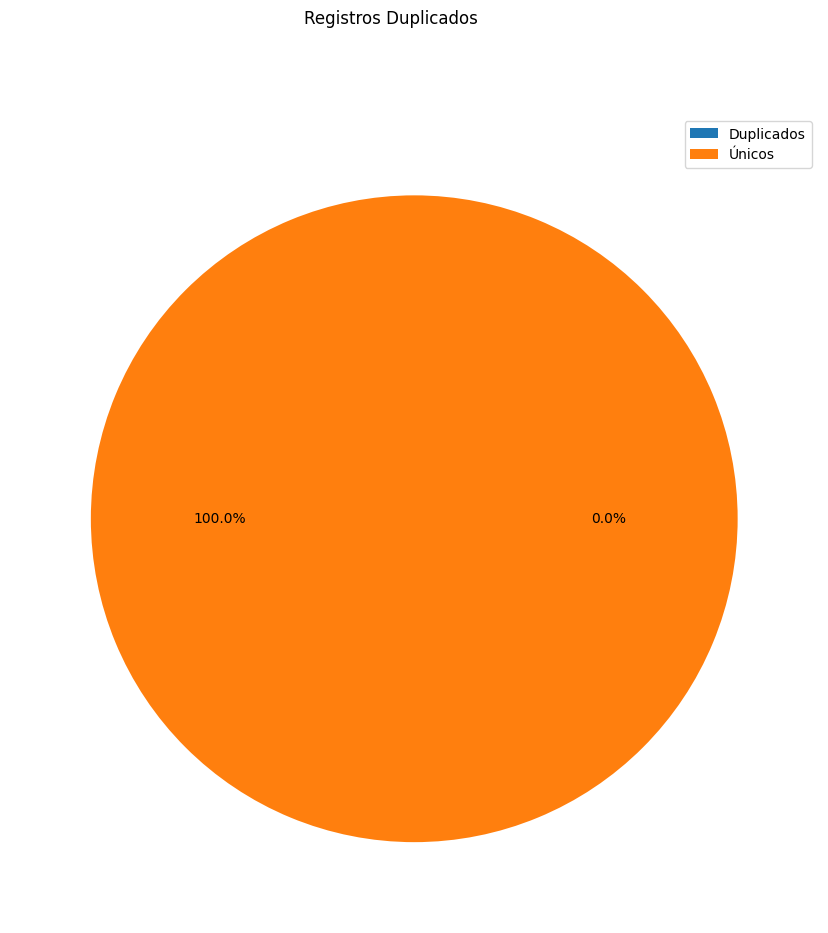

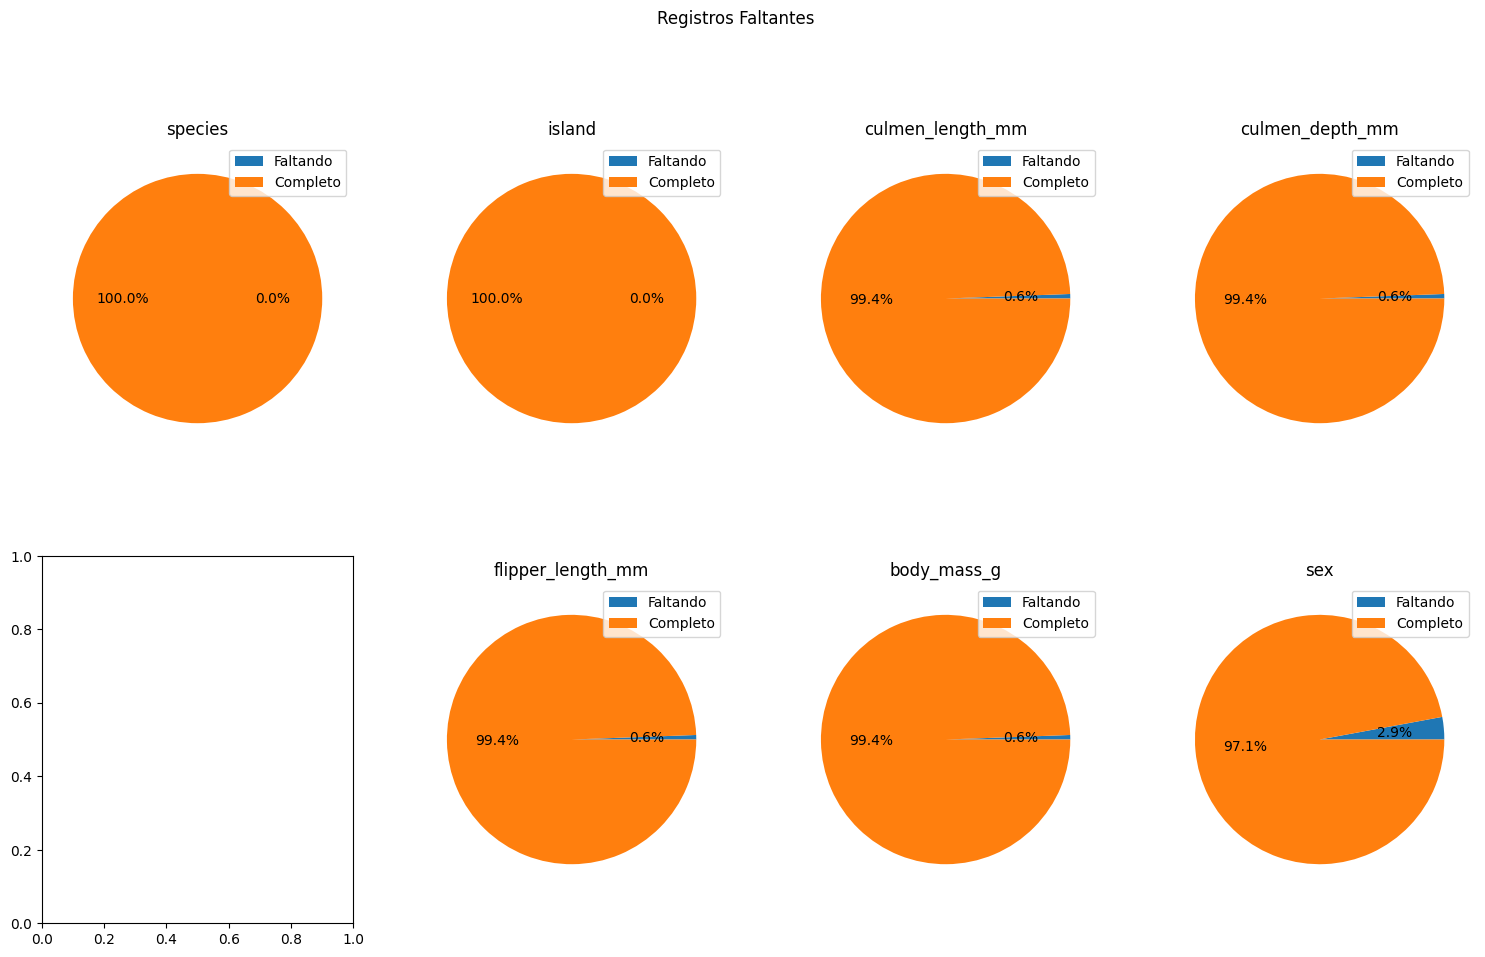

In [221]:
# check if datatype is the expected in each column
q.dtype_columns(df)

# check duplicated rows
q.duplicated(df)

# check missing data in each column
q.missing(df, df.columns)

# check boxplot
# df=df.dropna(axis=0)
# col=['culmen_length_mm', 	'culmen_depth_mm', 	'flipper_length_mm', 	'body_mass_g']
# sns.boxplot(x=df['species'], y=df['body_mass_g'])

Conclusão: Os tipos correspondem ao esperado (float64 para reais e object para strings). Não há registros duplicados. E há dados faltando nas colunas ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g", "sex"]. De acordo com o boxplot apenas a coluna "culmen_length_mm" tem um valor muito acima do padrao, porém acredito que este valor nao vai interferir nos resultados do modelo.

OBS: O sexo do pinguim não é relevante para a classificação de sua especie, entao esta coluna sera removida.

In [258]:
del df['sex'] # deleta coluna 'sex'

col=['culmen_length_mm', 	'culmen_depth_mm', 	'flipper_length_mm', 	'body_mass_g']  # colunas float (sera utilizada amplamente no codigo)

for i in df['species'].unique():
  print(df[col].loc[df['species'] == i].describe())
  print('-----------------------------------------------------------------------------------')


       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        272.000000       272.000000         272.000000   272.000000
mean          38.774233        18.361200         189.863800  3700.278170
std            2.651574         1.223906           6.561083   454.545937
min           32.100000        15.500000         172.000000  2850.000000
25%           36.800000        17.500000         185.000000  3350.000000
50%           38.800000        18.400000         190.000000  3700.000000
75%           40.800000        19.000000         195.000000  4000.000000
max           46.000000        21.500000         210.000000  4775.000000
----------------------------------------------------------------------------------------
       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        125.000000       125.000000         125.000000   125.000000
mean          48.804000        18.400000         195.648000  3736.000000
std            3.306187         1.1

Para preencher os valores faltantes utilizarei a media da especie.

OBS: Para isso tive que separa os dados de cada especie em um dataframe diferente e depois juntá-los em um unico novamente.

<ipython-input-259-dc9db9af37bc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ade[i] = df_ade[i].fillna(value=value)
<ipython-input-259-dc9db9af37bc>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi[i] = df_chi[i].fillna(value=value)
<ipython-input-259-dc9db9af37bc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

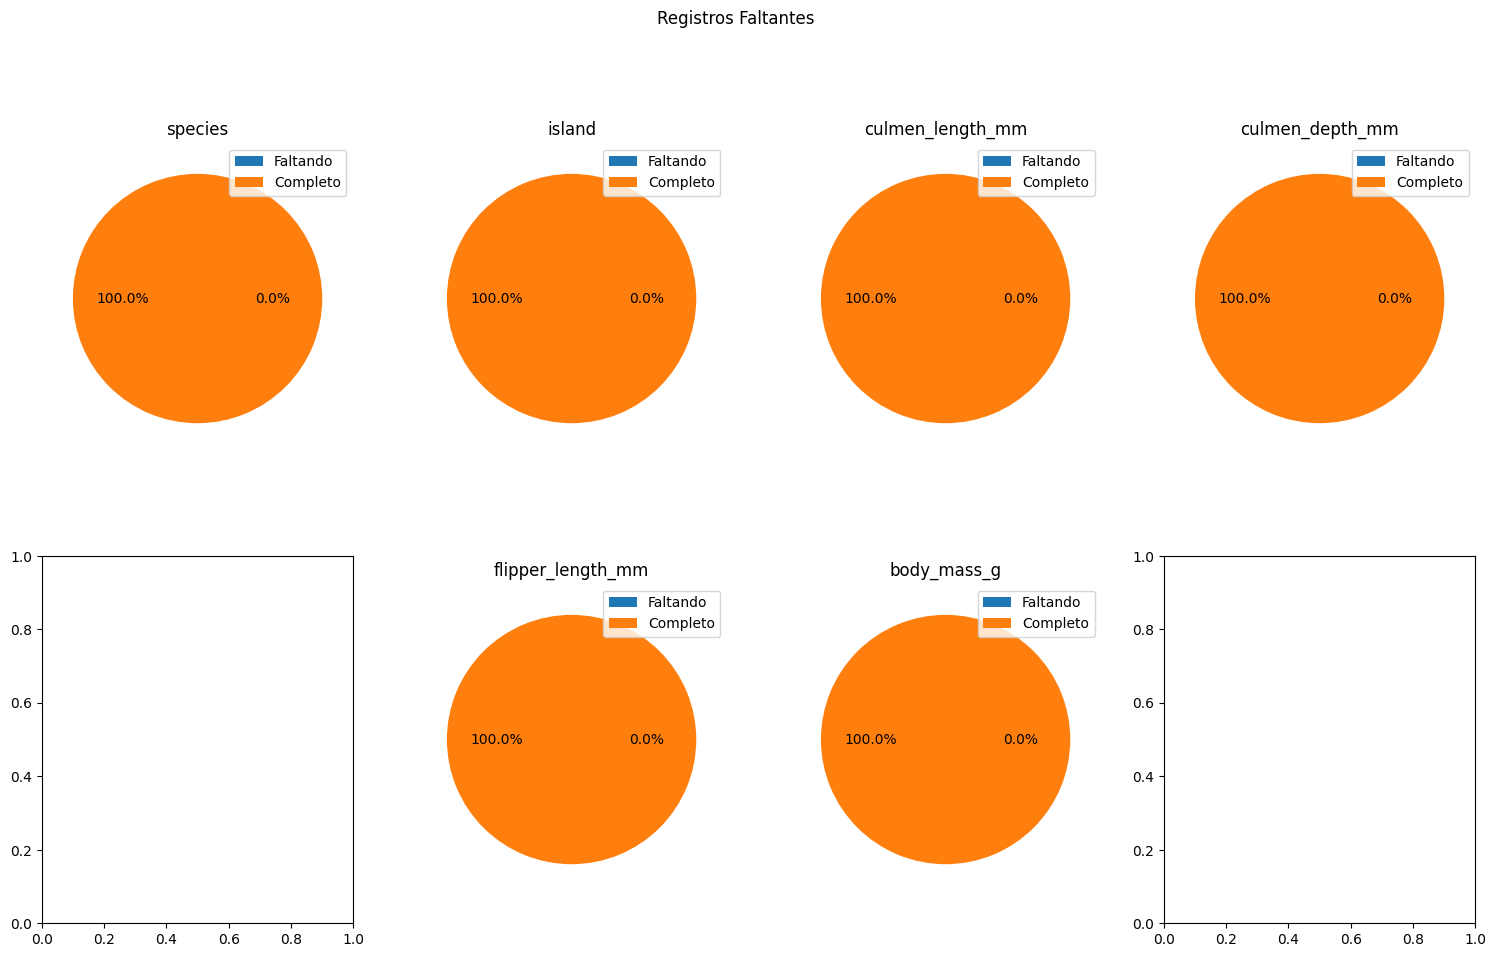

In [259]:
# selecting dfs by species
#df['species'].unique()
# returned -> ['Adelie', 'Chinstrap', 'Gentoo']
df_ade=df.loc[df['species'] == 'Adelie']
df_chi=df.loc[df['species'] == 'Chinstrap']
df_gen=df.loc[df['species'] == 'Gentoo']

# Adelie
for i in col:
  value = df_ade[i].mean()
  df_ade[i] = df_ade[i].fillna(value=value)

# Chinstrap
for i in col:
  value = df_chi[i].mean()
  df_chi[i] = df_chi[i].fillna(value=value)

# Gentoo
for i in col:
  value = df_gen[i].mean()
  df_gen[i] = df_gen[i].fillna(value=value)

# concat all dfs
df=df_ade
df=pd.concat([df, df_chi])
df=pd.concat([df, df_gen])

q.missing(df,df.columns)

# 2. 2. Pré-Processamento (Transformação)
Agora os dados precisam ser transformados e normalizados. A coluna "island" sera transformada em dado numerico (0, 1 e 2) e as colunas ['culmen_length_mm', 	'culmen_depth_mm', 	'flipper_length_mm', 	'body_mass_g'] serão normalizadas.

In [261]:
# transformação da coluna 'island'
#Label encoding (transforma atributos qualitativos em quantitativos)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['island'] = le.fit_transform(df['island'])
df['island'].unique()

# normalização
# from sklearn.preprocessing import RobustScaler
# x=df.pop('island')
# x1=df.pop('species')
# rs = RobustScaler()
# df = rs.fit_transform(df)
# df=pd.DataFrame(df, columns=col)
# df=pd.concat([df,x], axis=1)
# df=pd.concat([df,x1],axis=1)

array([2, 0, 1])

OBS: O modelo treinado com a normalização se saiu pior que o sem normalizar

# 3. Separação Train-Test

In [262]:
X_train = df.sample(frac=0.8, random_state=1)
df = pd.concat([df,X])
X_test = df.drop_duplicates(keep=False)

Y_train = X_train.pop('species')
Y_test = X_test.pop('species')

# print(X_train.head())
# print(Y_train.value_counts())
# print(X_test.head())
# print(Y_test.value_counts())

# 4. Construção do modelo (Random Forest)

3
n= 10 acc= 0.9855072463768116
n= 20 acc= 1.0
n= 30 acc= 1.0
n= 40 acc= 1.0
n= 50 acc= 1.0
n= 60 acc= 1.0
n= 70 acc= 1.0
n= 80 acc= 1.0
n= 90 acc= 1.0
Melhor valor de n: 16  com acurácia: 1.0


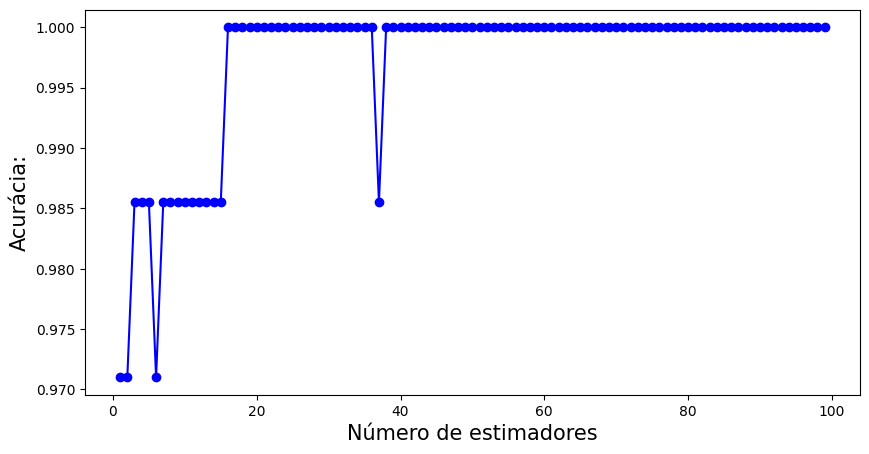

In [254]:
from sklearn.ensemble import RandomForestClassifier

# Verificação da acurácia mudando n_estimators
vscore = []
vn = []
state=random.randint(0,3) # guarda o valor passado como parametro no random_state

for n in range(1,100):
    model = RandomForestClassifier(n_estimators=n, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=state, verbose=0,
            warm_start=False)
    model.fit(X_train,Y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred, Y_test)
    vscore.append(score)
    vn.append(n)
    if(n%10 == 0):
      print('n= '+str(n)+' acc= '+str(score))

best_n = vn[np.argmax(vscore)]  # N melhor avaliado, sera utilizado na celula seguinte

# prints
print('Melhor valor de n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)] )
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Número de estimadores', fontsize = 15)
plt.ylabel('Acurácia:', fontsize = 15)
plt.show()

Com a célula acima verificamos graficamente como o modelo se comporta quando variamos seu n_estimators até 100. Além disso nas variaveis best_n e state são armazenados o melhor numero de estimadores calculado e o estado passado em random_state, respectivamente.

Best Number of Estimators: 16
In random_state= 3
Acurácia 1.0


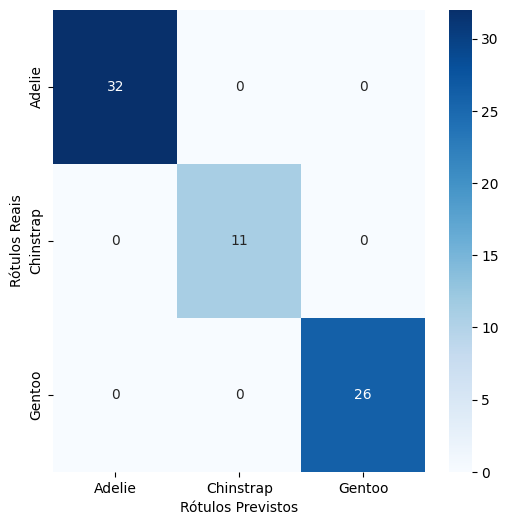

In [255]:
from sklearn.ensemble import RandomForestClassifier

print('Best Number of Estimators: '+str(best_n))
print('In random_state= '+str(state))

#Define os parâmetros do modelo
model = RandomForestClassifier(n_estimators=best_n, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=state, verbose=0,
            warm_start=False)

#Fita os dados
model.fit(X_train, Y_train)

#Calcula a predição + acurácia nos dados de teste
y_pred = model.predict(X_test)
score = accuracy_score(y_pred, Y_test)
print('Acurácia', score)

#Matriz de confusão
conf_matrix = confusion_matrix(Y_test, y_pred)

# Crie heat map com os nomes das classes
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=Y_test.unique(), yticklabels=Y_test.unique())
plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Reais')
plt.show()